In [1]:
import os
import sys
sys.path.append('../../')

import pandas as pd
import core.config as conf

In [2]:
path = conf.dataset_path

In [3]:
books = pd.read_csv(f'{path}' + 'books.csv')

In [4]:
ratings = pd.read_csv(f'{path}ratings.csv')

In [5]:
ratings=ratings.sort_values("user_id")

In [6]:
ratings.drop_duplicates(subset =["user_id","book_id"], 
                     keep = False, inplace = True) 

In [7]:
books.drop_duplicates(subset='original_title',keep=False,inplace=True)

In [8]:
fillnabooks= books.fillna('')

In [9]:
ratings.head()

,book_id,user_id,rating
117889,1180,1,4
488112,4893,1,3
625717,6285,1,4
796318,8034,2,4
875008,8855,2,5


In [10]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...


In [11]:
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [12]:
features=['original_title','authors','average_rating']
fillnabooks = fillnabooks[features]

In [13]:
fillnabooks = fillnabooks.astype(str)
fillnabooks.dtypes

original_title    object
authors           object
average_rating    object
dtype: object

In [14]:
for feature in features:
    fillnabooks[feature] = fillnabooks[feature].apply(clean_data)

In [15]:
fillnabooks.head()

,original_title,authors,average_rating
0,thehungergames,suzannecollins,4.34
1,harrypotterandthephilosopher'sstone,"j.k.rowling,marygrandpré",4.44
3,tokillamockingbird,harperlee,4.25
4,thegreatgatsby,f.scottfitzgerald,3.89
5,thefaultinourstars,johngreen,4.26


In [16]:
def create_soup(x):
    return x['original_title']+ ' ' + x['authors'] + ' ' + x['average_rating']

In [17]:
fillnabooks['soup'] = fillnabooks.apply(create_soup, axis=1)

In [18]:
fillnabooks.head()

,original_title,authors,average_rating,soup
0,thehungergames,suzannecollins,4.34,thehungergames suzannecollins 4.34
1,harrypotterandthephilosopher'sstone,"j.k.rowling,marygrandpré",4.44,harrypotterandthephilosopher'sstone j.k.rowlin...
3,tokillamockingbird,harperlee,4.25,tokillamockingbird harperlee 4.25
4,thegreatgatsby,f.scottfitzgerald,3.89,thegreatgatsby f.scottfitzgerald 3.89
5,thefaultinourstars,johngreen,4.26,thefaultinourstars johngreen 4.26


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(fillnabooks['soup'])

In [21]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [22]:
fillnabooks = fillnabooks.reset_index()
indices = pd.Series(fillnabooks.index, index = fillnabooks['original_title'])

In [23]:
indices.head()

original_title
thehungergames                         0
harrypotterandthephilosopher'sstone    1
tokillamockingbird                     2
thegreatgatsby                         3
thefaultinourstars                     4
dtype: int64

In [24]:
def get_recommendations_new(title, cosine_sim=cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return list(fillnabooks['original_title'].iloc[movie_indices])


In [25]:
l=get_recommendations_new('Harry Potter and The Chamber of Secrets', cosine_sim)

In [26]:
l

['harrypotterandtheorderofthephoenix',
 'harrypotterandthegobletoffire',
 'harrypotterandthedeathlyhallows',
 'harrypotterboxedsetbooks1-4',
 "harrypotterandthephilosopher'sstone",
 'harrypotterandtheprisonerofazkaban',
 'harrypotterandthehalf-bloodprince',
 'thecasualvacancy',
 'shadowkiss',
 'thetalesofbeedlethebard']

## Collaborative Filtering

In [27]:
usecols=['book_id', 'original_title']
books_col=books[usecols]

In [28]:
books_col = books_col.dropna()

In [29]:
books_col.head()

,book_id,original_title
0,2767052,The Hunger Games
1,3,Harry Potter and the Philosopher's Stone
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby
5,11870085,The Fault in Our Stars


In [30]:
from scipy.sparse import csr_matrix

In [31]:
# pivot ratings into movie features
df_book_features = ratings.pivot(index='book_id',columns='user_id',values='rating').fillna(0)
mat_book_features = csr_matrix(df_book_features.values)

In [36]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)


num_users = len(ratings.user_id.unique())
num_items = len(ratings.book_id.unique())
print('There are {} unique users and {} unique books in this data set'.format(num_users, num_items))


There are 53380 unique users and 10000 unique books in this data set


In [37]:
ratings=ratings.dropna()

In [38]:
df_ratings_cnt_tmp = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1,19485
2,63010
3,247698
4,355878
5,291198


In [42]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,532822731
1.0,19485
2.0,63010
3.0,247698
4.0,355878
5.0,291198


Text(0, 0.5, 'number of ratings')

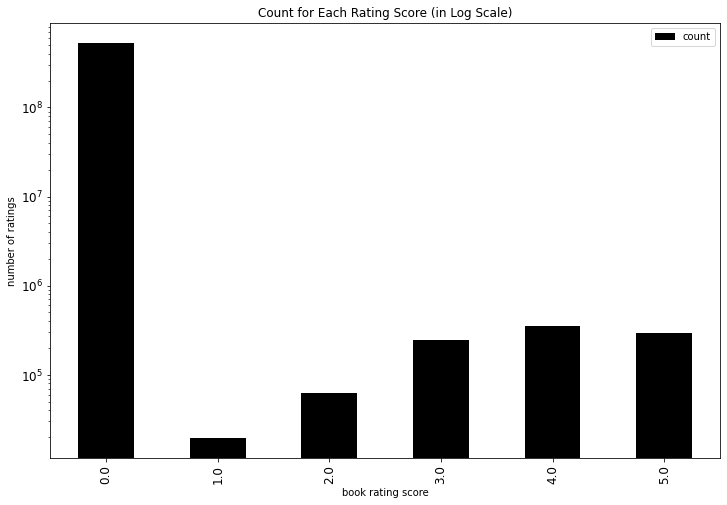

In [43]:
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

import matplotlib.pyplot as plt


get_ipython().run_line_magic('matplotlib', 'inline')
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,color='black'
)
ax.set_xlabel("book rating score")
ax.set_ylabel("number of ratings")


In [45]:


df_books_cnt = pd.DataFrame(ratings.groupby('book_id').size(), columns=['count'])
df_books_cnt.head()



,count
book_id,
1,100
2,100
3,100
4,100
5,100


In [46]:
#now we need to take only books that have been rated atleast 60 times to get some idea of the reactions of users towards it

popularity_thres = 60
popular_books = list(set(df_books_cnt.query('count >= @popularity_thres').index))
df_ratings_drop = ratings[ratings.book_id.isin(popular_books)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular books: ', df_ratings_drop.shape)

shape of original ratings data:  (977269, 3)
shape of ratings data after dropping unpopular books:  (975605, 3)


In [47]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()


,count
user_id,
1,3
2,3
3,2
4,3
5,5


In [49]:
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop[df_ratings_drop.user_id.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular books and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (977269, 3)
shape of ratings data after dropping both unpopular books and inactive users:  (417687, 3)


In [50]:


book_user_mat = df_ratings_drop_users.pivot(index='book_id', columns='user_id', values='rating').fillna(0)
book_user_mat



user_id,7,35,41,75,119,143,145,153,158,173,...,53245,53279,53281,53292,53293,53318,53352,53366,53373,53381
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:


book_user_mat_sparse = csr_matrix(book_user_mat.values)



In [52]:


book_user_mat_sparse



<9886x4892 sparse matrix of type '<class 'numpy.float64'>'
	with 417687 stored elements in Compressed Sparse Row format>

In [53]:


model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(book_user_mat_sparse)



NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [56]:
from fuzzywuzzy import fuzz


# In[24]:


def fuzzy_matching(mapper, fav_book, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True
    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_book.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

/home/nyongja/anaconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [59]:
def make_recommendation(model_knn, data, mapper, fav_book, n_recommendations):
    """
    return top n similar book recommendations based on user's input book
    Parameters
    ----------
    model_knn: sklearn model, knn model
    data: book-user matrix
    mapper: dict, map book title name to index of the book in data
    fav_book: str, name of user input book
    n_recommendations: int, top n recommendations
    Return
    ------
    list of top n similar book recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input book:', fav_book)
    idx = fuzzy_matching(mapper, fav_book, verbose=True)
    
    print('Recommendation system starting to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_book))
    rec=[]
    for i, (idx, dist) in enumerate(raw_recommends):
        if idx not in reverse_mapper.keys():
            continue
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))
        rec.append(reverse_mapper[idx])
    return rec

In [60]:


my_favorite = 'To Kill a Mockingbird'
indices = pd.Series(books_col.index, index=books_col['original_title'])



In [61]:
make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_book=my_favorite,
    mapper=indices,
    n_recommendations=10)


You have input book: To Kill a Mockingbird
Found possible matches in our database: ['To Kill a Mockingbird', 'Mockingbird', 'Stolen Songbird']

Recommendation system starting to make inference
......

Recommendations for To Kill a Mockingbird:
1: Lord of the Flies , with distance of 0.45598309432313877
2: Little Women, with distance of 0.4526896099993938
3: Nineteen Eighty-Four, with distance of 0.4396460119625992
4: Memoirs of a Geisha, with distance of 0.43283216907946764
5: Animal Farm: A Fairy Story, with distance of 0.4252435075403517
6: Pride and Prejudice, with distance of 0.4251608152166305
7: Of Mice and Men , with distance of 0.4204446294803902
8: Harry Potter and the Philosopher's Stone, with distance of 0.3892592020883805
9: The Catcher in the Rye, with distance of 0.3699905318987523
10: The Great Gatsby, with distance of 0.2966652339964868


['Lord of the Flies ',
 'Little Women',
 'Nineteen Eighty-Four',
 'Memoirs of a Geisha',
 'Animal Farm: A Fairy Story',
 'Pride and Prejudice',
 'Of Mice and Men ',
 "Harry Potter and the Philosopher's Stone",
 'The Catcher in the Rye',
 'The Great Gatsby']

In [62]:
make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_book='Harry Potter and the Chamber of Secrets',
    mapper=indices,
    n_recommendations=10)

You have input book: Harry Potter and the Chamber of Secrets
Found possible matches in our database: ['Harry Potter and the Chamber of Secrets', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.D', 'Gregor and the Marks of Secret', 'Harry Potter and the Half-Blood Prince', 'Harry Potter and the Order of the Phoenix', 'Harry Potter and the Prisoner of Azkaban', "Harry Potter and the Philosopher's Stone", 'Harry Potter and the Deathly Hallows', "James Potter and the Hall of Elders' Crossing ", 'Harry Potter and the Cursed Child, Parts One and Two', 'Haroun and the Sea of Stories']

Recommendation system starting to make inference
......

Recommendations for Harry Potter and the Chamber of Secrets:
1: The Return of the King, with distance of 0.5137453857083071
2: Mockingjay, with distance of 0.484811069871498
3: The Da Vinci Code, with distance of 0.48437188831920774
4: Catching Fire, with distance of 0.46678667832629206
5: Harr

['The Return of the King',
 'Mockingjay',
 'The Da Vinci Code',
 'Catching Fire',
 "Harry Potter and the Philosopher's Stone",
 'Harry Potter and the Deathly Hallows',
 'Harry Potter and the Half-Blood Prince',
 'Harry Potter and the Order of the Phoenix',
 'Harry Potter and the Goblet of Fire',
 'Harry Potter and the Prisoner of Azkaban']